<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tesseract

## Packages

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install imgaug==0.2.6
!pip install --ignore-installed Pillow==9.0.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (10.5 MB/s)
debconf: unable to initia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 4.9 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=5ba3162764f88414b081b8d4fb2309a67e8b6761f35170927c91d5df1567664e
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.9 MB/s 


In [2]:
import pytesseract
from pytesseract import Output
import os
import cv2 as cv
import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

## Dataset loading

### CTW1500 dataset

 - testing set (500 images)

Get images. Update location of images **manually**.

Comment if not using CTW1500 dataset.

In [250]:
# whether images are to be resized (skrinking)
resize = False
width = 3000

# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_images'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
                        
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
# images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# # threshold
# patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
# images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]
# # # closing 
# kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
# images = [cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) for img in images]    

# Get paths to files with labels. Update location manually
# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_ctw_test(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(read_gt_ctw_test(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

### KAISTdetectiondataset

In [231]:
# path to image and label directory, get full path to all files
directory = '/content/drive/MyDrive/Colab_Notebooks/VU/Kaist'

list_img_paths = []
list_bmp_paths = []
list_xml_paths = []
filenames = []
for path, dirs, files in os.walk(directory):
    for file in files:
        if(file.endswith(".jpg") or file.endswith(".JPG") ):
            list_img_paths.append(os.path.join(path, file))
            list_img_paths.sort()
            filenames.append(file)
        if(file.endswith(".bmp")):
            list_bmp_paths.append(os.path.join(path, file))
            list_bmp_paths.sort()
        if(file.endswith(".xml")):
            list_xml_paths.append(os.path.join(path, file))
            list_xml_paths.sort()


n_imgs = len(list_img_paths)
n_bmps = len(list_bmp_paths)
n_labels = len(list_xml_paths)

assert n_imgs == n_labels, "Check both xml and image files"

# whether images are to be resized (skrinking)
resize = False
width = 3000

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
# load images = bmp images (detected text)
# from already text detected images, which are provided in Kaist dataset
# original_images = [(cv.imread(file)) for file in list_bmp_paths]
  
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# threshold
patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]


# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_kaist(file, scaling_ratio=ratio))
else:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ground_truth.append(read_gt_kaist(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

395it [00:00, 732.21it/s]


## Prediction

Run OCR method.

In [251]:
# loop through all images in image directory

predictions = []
custom_config = r'--oem 3 --psm 11'

for img in tqdm(images):
    output = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)

    predictions.append(output)

100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


## Results postprocessing

Calculate bounding rectangles for detected words in an image.

For all images.

Replace polygon coordinates by these two rectangle coordinates.

In [252]:
# gather non empty predictions in a list of tuples (word, bounding_box_coordinates)
# predicted contains all images, each image can have multiple recognized words
# each image contains tuples in mentioned format

# in PyTesseract image_to_data returns a dictionary with results

predicted = []
for img in range(n_imgs):
    result = predictions[img]

    n = len(result['text'])
    results = []
    for i in range(n):
        word = result['text'][i]

        if len(word) > 0 and not word.isspace():
            coordinates = np.array([[result['left'][i],  result['top'][i]], [result['left'][i] +  result['width'][i], result['top'][i] + result['height'][i]]])
            results.append((word, coordinates))

    predicted.append(results)

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [253]:
iou_images = []
cer_images = []

# loop through images:
for i in range(n_imgs):
    if not predicted[i] and len(ground_truth[i]): 
        iou_images.append([(0, -1)])
        cer_images.append([[('', '', 1)]])
        continue
    elif len(ground_truth[i]):
        predicted_cols = list(zip(*predicted[i]))
    else:
        iou_images.append(None)
        cer_images.append(None)
        continue

    ground_truth_cols = list(zip(*ground_truth[i]))

    # take only coordinate arrays from list for each images
    pred_boxes = predicted_cols[1]
    gt_boxes = ground_truth_cols[1]
    iou_from_image = iou_image(pred_boxes, gt_boxes)

    iou_text_regions = group_text(iou_from_image)

    # take only labels for each image
    pred_labels = predicted_cols[0]
    gt_labels = ground_truth_cols[0]

    # compare corresponding labels
    # comparision is a list of all text regions on one image
    comparision = []
    for gt_ind, observation in enumerate(iou_text_regions):
        pred_ind = observation[1]
        predicted_text = " ".join([pred_labels[i] for i in pred_ind])
        gt_pred_text = (gt_labels[gt_ind], predicted_text)

        # comparision for one text region (on one image)
        comparision.append((compare_text_cer(gt_pred_text, special_characters=False, case_sensitive=False, split=True)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

In [254]:
iou_in_image = []
cer_in_image = []

for i in range(n_imgs):
    if isinstance(cer_images[i], list):
        length = len(cer_images[i])
        mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length) ])
        iou_in_image.append(average(list(zip(*iou_images[i]))[0]))
    else:
        mean_in_regions = None
        iou_in_image.append(None)
      
    cer_in_image.append(mean_in_regions)

### Overall results for dataset

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [255]:
# SELECT FROM OPTIONS BELOW OR CREATE YOUR OWN, COMMENT UNUSED:

# basic tesseract (original image size, case insensitive, only alphanumeric)
file_name = "tesseract_CTWtest_u_split"
specifications = ["tesseract untrained", "dataset: CTW1500", "original image size, case insensitive, only alphanumeric, split"]

# file_name = "tesseract_Kaist_u_nosplit"
# specifications = ["tesseract untrained", "dataset: Kaist", "original image size, case insensitive, only alphanumeric, no split"]

# file_name = "tesseract_Kaist_bmp_u_nosplit"
# specifications = ["tesseract untrained", "dataset: Kaist bmp", "original image size, case insensitive, only alphanumeric, no split"]

In [256]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean() * 100, 1)
mean_cer = round((1 - df_results['CER'].mean()) * 100, 1)

print(file_name, ": ", specifications[-1])
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

tesseract_Kaist_bmp_u_nosplit_11 :  original image size, case insensitive, only alphanumeric, no split, 11
mean IoU accuracy = 47.6%, mean CER accuracy = 16.2%


,Filename,IoU,CER
0,1001.jpg,0.479385,0.300000
1,1002.jpg,0.578032,0.900000
2,1003.jpg,0.236785,1.000000
3,1004.jpg,0.117499,0.940217
4,1005.jpg,0.291884,0.901786
...,...,...,...
495,1496.jpg,0.735789,0.824521
496,1497.jpg,0.759163,0.628326
497,1498.jpg,0.888955,0.825000
498,1499.jpg,0.427047,0.844841


### Save results

In [257]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Save to file.

In [258]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

In [259]:
cer_images[393]

[[('xf3', '', 1), ('xf3', 'a', 1.0), ('xf3', 'a', 1.0)]]

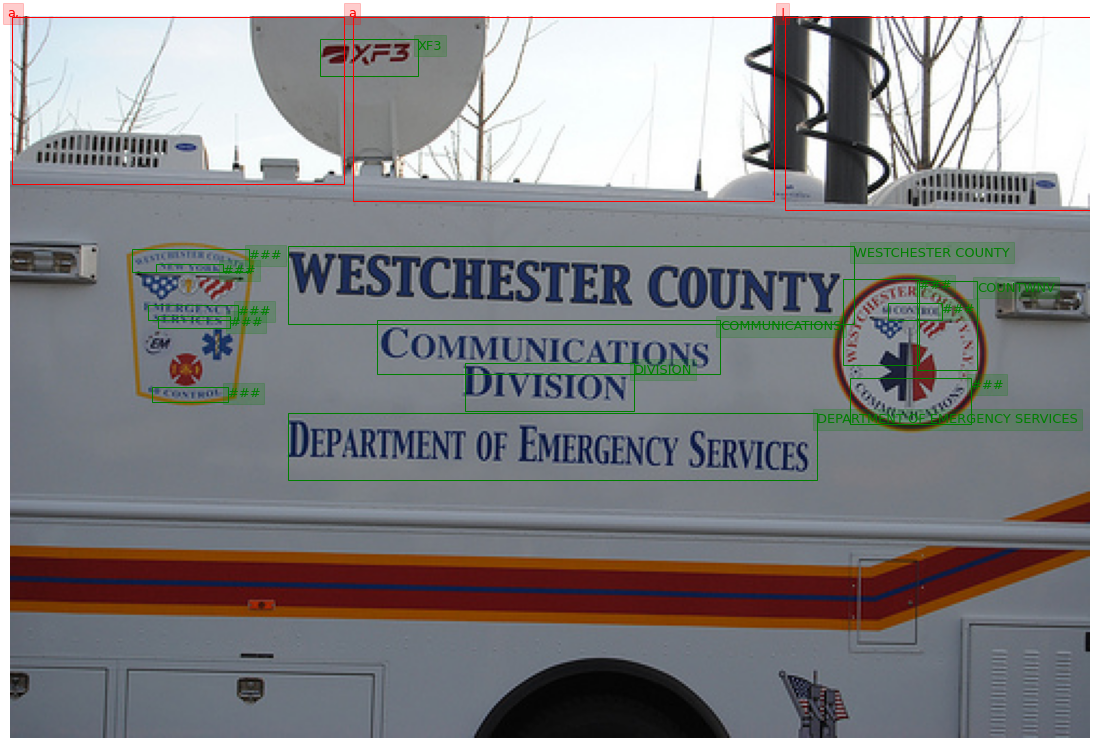

In [260]:
# all images / one sample image
# for i in range(n_imgs):
i = 393

im = plot_results(images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
